In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
# Use GridSearchCV to find the best parameters for the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, RocCurveDisplay, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from xgboost import XGBClassifier

# Anomaly Detection using One class SVM

## Pre-process data

In [13]:
df = pd.read_csv('data_normalized.csv')

df.head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
0,0.020966,0.008204,0.275294,0.932534,0.007293,0.000912,0.0,0.232450,0.0,0.000000,0
1,0.510391,0.112037,0.597531,0.597531,0.012449,0.012449,0.0,0.112037,0.0,0.000249,0
2,0.010758,0.004210,0.156231,0.980420,0.002807,0.000468,0.0,0.119278,0.0,0.000000,0
3,0.012592,0.004927,0.115521,0.983297,0.010402,0.000547,0.0,0.139611,0.0,0.000000,0
4,0.044541,0.017429,0.406674,0.766872,0.019365,0.001937,0.0,0.493819,0.0,0.000000,0


In [14]:
# process data, 1: normal; [0, 3, 4] -> -1: abnormal
df['target'] = df['target'].apply(lambda x: -1 if x==1  else 1)

df['target'].value_counts()

 1    206854
-1     28591
Name: target, dtype: int64

## Split data 
In this part, we are trying to conduct novelty detection, which is a kind of anomaly detection: https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
Use normal data as the training data, and abnormal data + normal data as the testing data

In [15]:
# get normal and abnormal data in df
y = df[df['target'] == 1]['target']
X = df[df['target'] == 1].drop(['target'], axis=1, inplace=False)

y_outlier = df[df['target'] == -1]['target']
X_outlier = df[df['target'] == -1].drop(['target'], axis=1, inplace=False)

# split data into train and test
# 50% normal only data for training
X_train, X_test_normal, y_train, y_test_normal = train_test_split(X, y, test_size=0.3, random_state=42)

# 50% normal + 50% abnormal data for testing
_, X_test_ab, _, y_test_ab = train_test_split(X_outlier, y_outlier, test_size=0.5, random_state=42)

# # # prepare data for testing
X_test = pd.concat([X_test_normal, X_test_ab])
y_test = pd.concat([y_test_normal, y_test_ab])




## Fine tune model
Use GridSearchCV to fine-tune the model and find the best parameter set.

In [5]:
# only run this if you want to train on a portion of dataset
X_train = X_train.iloc[:5000, :]
y_train = y_train.iloc[:5000]

X_test1 = X_test.iloc[:2500, :]
X_test2 = X_test.iloc[-2500:, :]
y_test1 = y_test.iloc[:2500]
y_test2 = y_test.iloc[-2500:]

X_test = pd.concat([X_test1, X_test2], axis=0)
y_test = pd.concat([y_test1, y_test2], axis=0)

In [12]:
# suppress `zero_division` warning (we are just using normal data to train)
import warnings
warnings.filterwarnings('ignore')

nus = [0.001, 0.05, 0.1, 0.5]
gammas = [0.005, 0.01, 0.1, 0.25, 0.5, 1]

tuned_parameters = {'gamma' : gammas, 'nu': nus}
clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=5, scoring='f1', return_train_score=True)

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'gamma': 0.005, 'nu': 0.1}


## Train the model with the best parameter set

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train)
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[1, -1], display_labels=['Normal', 'Abormal'])
    # remove grid lines
    # plt.grid(False)
    plt.show()
    return y_pred

In [17]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.005, nu = 0.1).fit(X_train)
# predict normal and abnormal data
y_pred = model.predict(X_test)


In [18]:
accuracy_score(y_test, y_pred)

0.8913467709192828


============================== OneClassSVM Model Evaluation ==============================

Model Accuracy:
 0.8913467709192828

Classification report:
               precision    recall  f1-score   support

          -1       0.66      0.85      0.75     14296
           1       0.96      0.90      0.93     62057

    accuracy                           0.89     76353
   macro avg       0.81      0.88      0.84     76353
weighted avg       0.91      0.89      0.90     76353




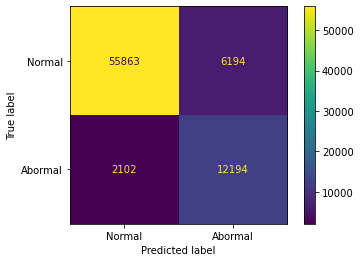

In [21]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.005, nu = 0.1)

y_pred = train_classifier(('OneClassSVM', model), X_train, y_train, X_test, y_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# then you can plot(fpr, tpr) to get the roc curve and compute the AUC with:
AUC = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(8,6))
# plot the roc curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % AUC)
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
# set x label as false positive rate
ax.set_xlabel("False Positive Rate", fontsize=16)
# set y label as true positive rate
ax.set_ylabel("True Positive Rate", fontsize=16)
# set legend 
ax.legend(loc="lower right", fontsize=14)
plt.show()

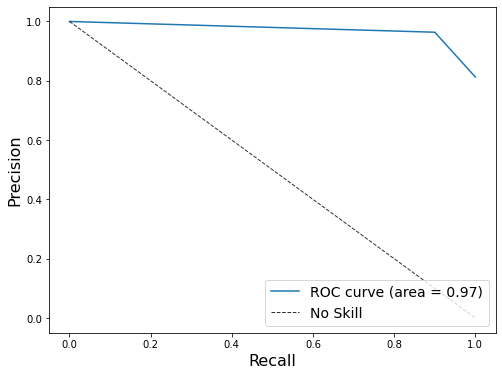

In [20]:
from sklearn.metrics import precision_recall_curve

lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)

lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)

fig, ax = plt.subplots(figsize=(8,6))
# plot the roc curve
plt.plot(lr_recall, lr_precision, label='ROC curve (area = %0.2f)' % lr_auc)
ax.plot([0, 1], [1, 0], linestyle='--', lw=1, color='k', label='No Skill', alpha=.8)
# set x label as false positive rate
ax.set_xlabel("Recall", fontsize=16)
# set y label as true positive rate
ax.set_ylabel("Precision", fontsize=16)
# set legend 
ax.legend(loc="lower right", fontsize=14)
plt.show()

## Misused Detection (Machine Learning Algorithms)

In [69]:
df = pd.read_csv('data_normalized.csv')
# keep only the columns ['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate']
# df = df[['duration', 'protocol_type', 'service', 'src_bytes', 'hot', 'num_failed_logins', 'srv_count', 'same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate', 'target']]
df.head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_srv_serror_rate,dst_host_diff_srv_rate,target
0,0.020966,0.008204,0.275294,0.932534,0.007293,0.000912,0.0,0.232450,0.0,0.000000,0
1,0.510391,0.112037,0.597531,0.597531,0.012449,0.012449,0.0,0.112037,0.0,0.000249,0
2,0.010758,0.004210,0.156231,0.980420,0.002807,0.000468,0.0,0.119278,0.0,0.000000,0
3,0.012592,0.004927,0.115521,0.983297,0.010402,0.000547,0.0,0.139611,0.0,0.000000,0
4,0.044541,0.017429,0.406674,0.766872,0.019365,0.001937,0.0,0.493819,0.0,0.000000,0


In [70]:
# 0 for normal conn., 1 for abnormal conn.
y = df['target']
X = df.drop(['target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:

def train_classifier(models, X_train, y_train, X_test, y_test):
    model_name, model = models
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    classification = metrics.classification_report(y_test, y_pred)
    print()
    print(f"============================== {model_name} Model Evaluation ==============================")
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Classification report:" "\n", classification) 
    print()
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    # remove grid lines
    # plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(False)
    plt.show()
    return y_pred


In [73]:
# function to plot roc curve
def plot_kfold_roc_curve(classifier,X,y,title):

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5)

    # defining the lists
    tprs = []
    aucs = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots(figsize=(8,6))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train].values.ravel())
        # Compute ROC curve and area under the curve (roc/auc)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {i}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_pred = classifier.predict(X.iloc[test])
        f1s.append(f1_score(y_true = y.iloc[test],y_pred = y_pred))
    print(f"average f1 score is: {sum(f1s)/len(f1s)}")
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=title,
    )
    ax.legend(loc="lower right")
    plt.show()
    

In [87]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc, f1_score, precision_recall_curve


# refered to code: https://amirhessam88.github.io/roc-vs-pr/
def plot_prc_curve(classifier, X, y, n_folds=5):
    """
    Function to:
    1. train RF classification model using cross-validation, 
    2. plot PRC curve, and 
    3. get avg F1 score
    """
    
    cv = StratifiedKFold(n_splits=n_folds)
    

    # defining the lists
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    f1_score_lst = []
    
    plt.figure(figsize=(9, 7))
    index = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train].values.ravel()).predict_proba(X.iloc[test])
        # Compute PR curve and area under the curve
        precision, recall, thresholds = precision_recall_curve(y.iloc[test], probas_[:, 1])
        prs.append(np.interp(mean_recall, precision, recall))
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        
        # append f1 score
        y_pred = classifier.predict(X.iloc[test])
        rf_f1 = f1_score(y_true=y.iloc[test], y_pred=y_pred)
        f1_score_lst.append(rf_f1)
        
        
        plt.plot(recall, precision, lw=1, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (index+1, pr_auc))
        index += 1
    
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='k', label='No Skill', alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    f1_array = np.array(f1_score_lst)
    print(f"average F1-scores: {np.mean(f1_array)}")
    plt.plot(mean_precision, mean_recall, color='navy',
             label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2)
    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=30)
    plt.ylabel('Precision',fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend( prop={'size':20} , loc = 0)
    plt.show()

### Weak Learners (Naive Bayes Classifier)


============================== Naive Bayes Model Evaluation ==============================

Cross Validation Mean Score:
 0.9544508588776995

Model Accuracy:
 0.9559135826938868

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     62073
           1       0.79      0.86      0.83      8561

    accuracy                           0.96     70634
   macro avg       0.89      0.92      0.90     70634
weighted avg       0.96      0.96      0.96     70634




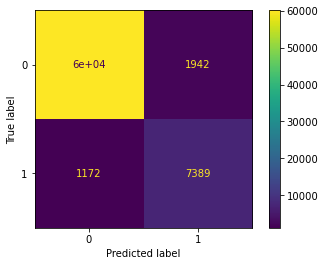

array([0, 0, 0, ..., 0, 1, 0])

In [75]:
from sklearn.naive_bayes import GaussianNB
train_classifier(("Naive Bayes", GaussianNB()), X_train, y_train, X_test, y_test)

average f1 score is: 0.8351997867841705


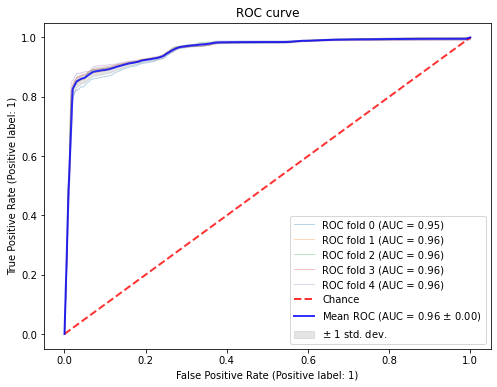

In [68]:
classifier = GaussianNB()
plot_kfold_roc_curve(classifier, X, y, title = "ROC curve")

average F1-scores: 0.8203352755508305


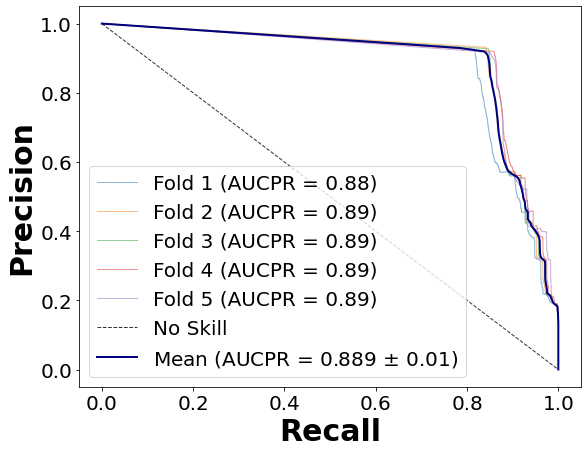

In [81]:
classifier = GaussianNB()
plot_prc_curve(classifier, X, y)

### Weak Learners (Linear model: Ridge Classifier)

In [82]:
from sklearn.linear_model import RidgeClassifier
# train_classifier(("Ridge Classifier", RidgeClassifier()), X, y_train, X_test, y_test)

average f1 score is: 0.8890518993707424


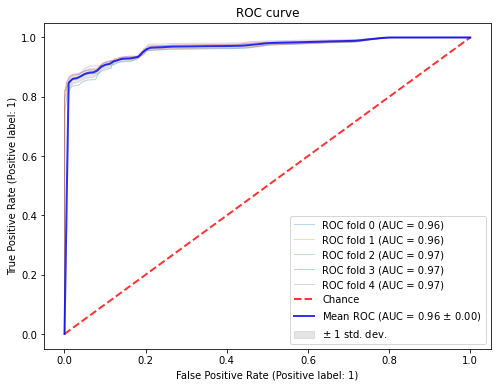

In [83]:
classifier = RidgeClassifier()
plot_kfold_roc_curve(classifier, X, y, title = "ROC curve")

In [84]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import auc, f1_score, precision_recall_curve


# refered to code: https://amirhessam88.github.io/roc-vs-pr/
def plot_prc_curve(classifier, X, y, n_folds=5):
    """
    Function to:
    1. train RF classification model using cross-validation, 
    2. plot PRC curve, and 
    3. get avg F1 score
    """
    
    cv = StratifiedKFold(n_splits=n_folds)
    
    # classifier = RidgeClassifierCVwithProba()
    # defining the lists
    prs = []
    aucs = []
    mean_recall = np.linspace(0, 1, 100)
    f1_score_lst = []
    
    plt.figure(figsize=(9, 7))
    index = 0
    for train, test in cv.split(X, y):
        
        probas_ = classifier.fit(X.iloc[train], y.iloc[train].values.ravel()).decision_function(X.iloc[test])
        # Compute PR curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y.iloc[test], probas_)
        prs.append(np.interp(mean_recall, precision, recall))
        pr_auc = auc(recall, precision)
        aucs.append(pr_auc)
        
        # append f1 score
        y_pred = classifier.predict(X.iloc[test])
        rf_f1 = f1_score(y_true=y.iloc[test], y_pred=y_pred)
        f1_score_lst.append(rf_f1)
        
        
        plt.plot(recall, precision, lw=1, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (index+1, pr_auc))
        index += 1
    
    plt.plot([0, 1], [1, 0], linestyle='--', lw=1, color='k', label='No Skill', alpha=.8)
    mean_precision = np.mean(prs, axis=0)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucs)
    f1_array = np.array(f1_score_lst)
    print(f"average F1-scores: {np.mean(f1_array)}")
    plt.plot(mean_precision, mean_recall, color='navy',
             label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2)
    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=30)
    plt.ylabel('Precision',fontweight = "bold" , fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend( prop={'size':20} , loc = 0)
    plt.show()

average F1-scores: 0.8890518993707424


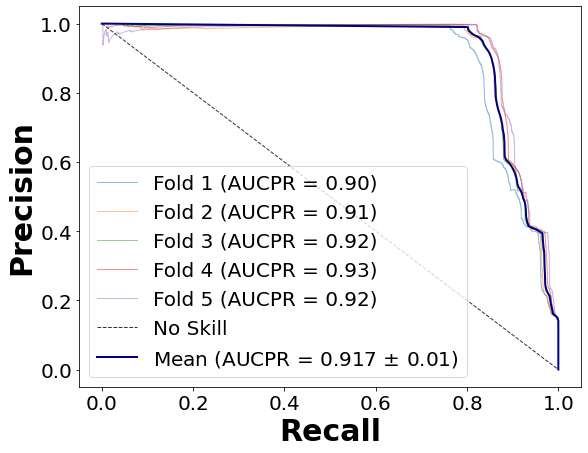

In [46]:
classifier = RidgeClassifier()
plot_prc_curve(classifier, X, y)

### RandomForest Classifier


============================== Random Forest Model Evaluation ==============================

Cross Validation Mean Score:
 0.9986772733805054

Model Accuracy:
 0.9988532434804768

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62073
           1       1.00      0.99      1.00      8561

    accuracy                           1.00     70634
   macro avg       1.00      1.00      1.00     70634
weighted avg       1.00      1.00      1.00     70634




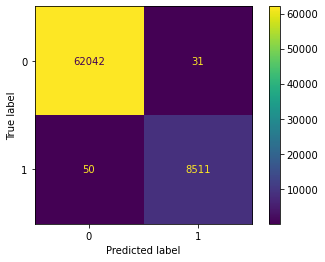

array([0, 0, 0, ..., 0, 1, 0])

In [85]:
train_classifier(("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)), X_train, y_train, X_test, y_test)

average F1-scores: 0.9736779209580302


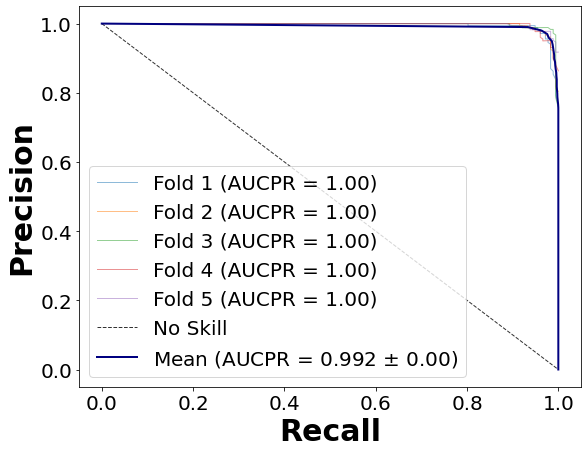

In [95]:
classifier = RandomForestClassifier(n_estimators=100)
plot_prc_curve(classifier, X, y)

## XGBoost Classifier


============================== XGBoost Model Evaluation ==============================

Cross Validation Mean Score:
 0.9987015415435749

Model Accuracy:
 0.9989806608715349

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     62073
           1       1.00      0.99      1.00      8561

    accuracy                           1.00     70634
   macro avg       1.00      1.00      1.00     70634
weighted avg       1.00      1.00      1.00     70634




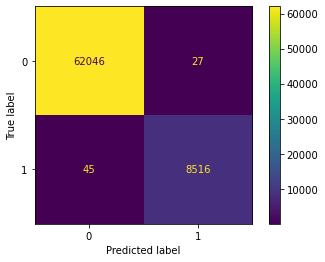

array([0, 0, 0, ..., 0, 1, 0])

In [89]:
# Train XGBoost Classifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=42)

train_classifier(("XGBoost", xgbc), X_train, y_train, X_test, y_test)

average F1-scores: 0.9683481760876969


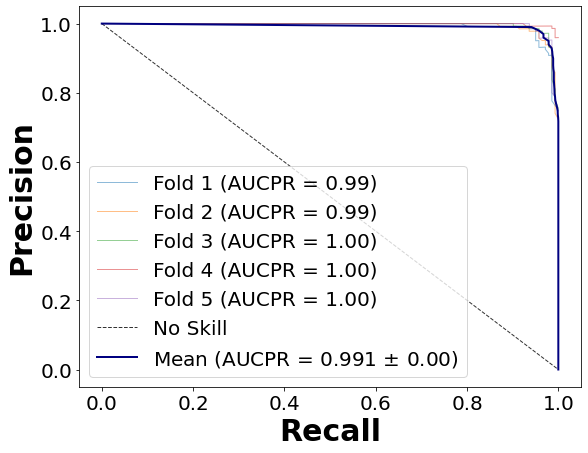

In [96]:
plot_prc_curve(classifier, X, y)